In [1]:
import sys
sys.path.append('../')
from Code.envs.statemachine import run, make_rythm
import torch
import torch.nn as nn
import torch.optim as optim
import time
from collections import OrderedDict

from PIL import Image
import numpy as np


In [2]:
standard = {'beta': 0.8,
   'lr': 0.001,
   'NoBias': False, #no effect
   'iterations': 5000,
   'batch_size': 64,
   'spkfn': 'bellec',
   'decay_out': False,
   'control_neuron': 'LIF',
}

spec = {
    **standard,
   '1-beta': 'improved',
   'decay_change': 1,
   'architecture': '1L',
   'mem_neuron': 'Adaptive',
   'char_dur': 2,
   'n_mem': 10
}

#spec['1-beta'] = False
#spec['beta'] = 1

In [3]:
BATCH_SIZE = spec['batch_size']

device = torch.device('cuda')

SEQ_LEN = 30
CHAR_DUR = spec['char_dur']

perm_num = 8
n_input = perm_num + CHAR_DUR
n_out = perm_num
n_control = 100
n_mem = spec['n_mem']

MAIN_DECAY = np.exp(-1/(CHAR_DUR*spec['decay_change']))
INPUT_RATE = 1.5/n_input

In [4]:
#MAIN_DECAY = 1# = 0.99
MAIN_DECAY = np.exp(-1/(CHAR_DUR)*0.5)
ADAP_DECAY = np.exp(-1/(CHAR_DUR*2))



In [5]:
from Code.everything4 import DynNetwork, OuterWrapper, BaseNeuron, SequenceWrapper, ParallelNetwork, \
 SeqOnlySpike, CooldownNeuron, OutputNeuron, LIFNeuron, NoResetNeuron, AdaptiveNeuron, FlipFlopNeuron, ParallelNetwork2


built_config = {
    'BETA': spec['beta'],
    'OFFSET': -np.log(1-MAIN_DECAY),#-np.log(1-spec['beta']),#3, # TODO: was 3 for config24
    'SPIKE_FN': spec['spkfn'],
    '1-beta': spec['1-beta'],
    'ADAPDECAY': ADAP_DECAY, #0.9985,
    'ADAPSCALE': 30#180
}

#built_config['ADAPDECAY'] = 0.99

mem_config = {
    **built_config,
    'BETA': spec['beta'] if spec['mem_neuron'] in ['Adaptive', 'LIF'] else MAIN_DECAY
}



control_lookup = {
    'LIF': LIFNeuron,
    'Disc': SeqOnlySpike,
    'NoReset': NoResetNeuron
}

mem_lookup = {
    'Adaptive': AdaptiveNeuron,
    'Cooldown': CooldownNeuron,
    'NoReset': NoResetNeuron,
    'FlipFlop': FlipFlopNeuron,
    'LIF': LIFNeuron
}

control_neuron = control_lookup[spec['control_neuron']](n_control, built_config)
mem_neuron = mem_lookup[spec['mem_neuron']](n_mem, mem_config)
out_neuron_size = n_mem if spec['architecture'] == '2L' else n_mem+n_control
out_neuron = OutputNeuron(out_neuron_size, built_config) if spec['decay_out'] else BaseNeuron(out_neuron_size, built_config)
#out_neuron = LIFNeuron(n_control, built_config)
#TODO: fix this for 1L

#from mem only
loop_2L = OrderedDict([
    ('input', (n_input, INPUT_RATE)),
    ('control', [['input', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['control'], mem_neuron, nn.Linear]),
    ('output', [['mem'], out_neuron, None]),
])


loop_1L = OrderedDict([
    ('input', (n_input, INPUT_RATE)),
    ('control', [['input', 'control', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['input', 'control', 'mem'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])

loop = loop_1L if spec['architecture'] == '1L' else loop_2L

outer = OrderedDict([
    ('input', n_input),
    ('loop', [['input'], SequenceWrapper(ParallelNetwork2(loop, bias=(not spec['NoBias']))), None]),
    ('output', [['loop'], BaseNeuron(n_out, None), nn.Linear]),
])

model = OuterWrapper(DynNetwork(outer), device)


params = list(model.parameters())

model.to(device)


OrderedDict([('control', [[('input', 1), ('control', 1), ('mem', 1)], LIFNeuron(), <class 'torch.nn.modules.linear.Linear'>]), ('mem', [[('input', 1), ('control', 1), ('mem', 1)], AdaptiveNeuron(), <class 'torch.nn.modules.linear.Linear'>]), ('output', [[('control', 1), ('mem', 1)], BaseNeuron(), None])])


OuterWrapper(
  (model): DynNetwork(
    (layers): ModuleDict(
      (loop): SequenceWrapper(
        (model): ParallelNetwork2(
          (layers): ModuleDict(
            (control): LIFNeuron()
            (control_synapse): Linear(in_features=120, out_features=100, bias=True)
            (mem): AdaptiveNeuron()
            (mem_synapse): Linear(in_features=120, out_features=10, bias=True)
            (output): BaseNeuron()
          )
        )
      )
      (output_synapse): Linear(in_features=110, out_features=8, bias=True)
      (output): BaseNeuron()
    )
  )
)

In [6]:
lr = spec['lr']
optimizer = optim.Adam(params, lr=lr)
#bce = nn.BCEWithLogitsLoss(reduction='none')
#ce = nn.CrossEntropyLoss() #reduction='none'


ITERATIONS = spec['iterations']#36000


lookup = torch.tensor([[6, 1, 4, 5, 7, 2, 0, 3],
        [7, 0, 4, 2, 3, 1, 5, 6],
        [0, 5, 6, 2, 4, 3, 7, 1],
        [2, 7, 6, 4, 3, 1, 5, 0],
        [0, 6, 4, 5, 2, 1, 7, 3],
        [5, 1, 0, 6, 4, 7, 3, 2],
        [4, 6, 1, 2, 5, 7, 0, 3],
        [2, 7, 4, 3, 5, 6, 0, 1]], dtype=torch.long, device=device)

In [7]:
seql = 100

val_rythm = make_rythm(BATCH_SIZE, 100, CHAR_DUR, device)
def validate():
    acc, _, _ = run(model, lookup, val_rythm, BATCH_SIZE, 100, CHAR_DUR, perm_num, device)
    print('Validation: ', acc)

stats = {
    'grad_norm': [],
    'loss': [],
    'acc': [],
    'batch_var': [],
    'val': []
}

grad_norm_history = []
def record_norm():
    norms = []
    for p in params:
        norms.append(p.grad.norm().item())
    stats['grad_norm'].append(torch.tensor(norms).norm().item())
    #print(stats['grad_norm'][-1])



In [8]:
train_rythm = make_rythm(BATCH_SIZE, SEQ_LEN, CHAR_DUR, device)


start = time.time()
i = 1
sumloss = 0
sumacc = 0

while i < ITERATIONS:
    batchstart = time.time()
    optimizer.zero_grad()
    acc, loss, _ = run(model, lookup, train_rythm, BATCH_SIZE, SEQ_LEN, CHAR_DUR, perm_num, device)

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        record_norm()
        stats['loss'].append(loss.item())
        #acc = ((((output > 0).float() == target).float()*recall).sum()/recall.sum()).item()
        #stats['acc'].append(acc)
        batch_var = 3 #out_final.var(0).mean().item()
        #stats['batch_var'].append(batch_var)

        #print(loss.item(), acc1, acc2)


    sumloss += loss.item()
    sumacc += acc
    if i%20 == 0:
        print(sumacc/20, i)
        #print(loss.item(), sumloss/20, sumacc/20, time.time()-batchstart, batch_var) #torch.argmax(outputs[-1], 1).float().var()
        sumloss = 0
        sumacc = 0
    if i%100 == 0:
        validate()
    i += 1
    #config['stats'] = stats
    #config['progress'] = i
    #with open('configs/' + run_id + '.json', 'w') as config_file:
    #    json.dump(config, config_file, indent=2)
    #model.save('models/'+run_id)


print('Total time: ', time.time()-start)


0.14477370567619802 20
0.18674568980932235 40
0.22031249850988388 60
0.2554148696362972 80
0.27521551847457887 100
Validation:  0.30366161465644836
0.292349137365818 120
0.31109913289546964 140
0.31821120977401735 160
0.33168102949857714 180
0.3449084058403969 200
Validation:  0.359375
0.36139547675848005 220
0.3633890077471733 240
0.3735991358757019 260
0.3592402994632721 280
0.38060344755649567 300
Validation:  0.39472854137420654
0.37556573152542116 320
0.387284480035305 340
0.39824891835451126 360
0.4156250014901161 380
0.4261853456497192 400
Validation:  0.4201388955116272
0.4335398688912392 420
0.4476023703813553 440
0.4612607717514038 460
0.4877155154943466 480
0.498545253276825 500
Validation:  0.4848484992980957
0.5027747809886932 520
0.5108028009533883 540
0.5263200402259827 560
0.5259967729449272 580
0.5360991358757019 600
Validation:  0.5320391654968262
0.5404633581638336 620
0.5498652994632721 640
0.5569234848022461 660
0.5667564600706101 680
0.569181028008461 700
Validati

In [9]:
MAIN_DECAY

0.7788007830714049

In [10]:
validate()


Validation:  0.7784090638160706


In [11]:
lookup

tensor([[6, 1, 4, 5, 7, 2, 0, 3],
        [7, 0, 4, 2, 3, 1, 5, 6],
        [0, 5, 6, 2, 4, 3, 7, 1],
        [2, 7, 6, 4, 3, 1, 5, 0],
        [0, 6, 4, 5, 2, 1, 7, 3],
        [5, 1, 0, 6, 4, 7, 3, 2],
        [4, 6, 1, 2, 5, 7, 0, 3],
        [2, 7, 4, 3, 5, 6, 0, 1]], device='cuda:0')

In [12]:
train_rythm = make_rythm(BATCH_SIZE, SEQ_LEN, CHAR_DUR, device)

_, _, info = run(model, lookup, train_rythm, BATCH_SIZE, SEQ_LEN, CHAR_DUR, perm_num, device, logging=True)

input, log = info
ar_length = input.shape[0]
array_list = [input, log['loop']['control'], log['loop']['mem'], log['output']] #log['loop']['output']
array_list2 = []
for ar in array_list:
    array_list2.append(ar[:, 0])
    array_list2.append(torch.ones((ar_length, 1), device=input.device) * 0.5)
big_ar = torch.cat(array_list2[:-1], dim=1).detach() * 255
img = Image.fromarray(big_ar.cpu().numpy().astype(np.uint8), 'L')

In [13]:
img.size

(131, 60)

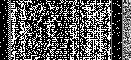

In [14]:
img
#img.resize((239, 600))

In [15]:
log['loop']['control'].mean()

tensor(0.3839, device='cuda:0', grad_fn=<MeanBackward0>)

In [16]:
log['loop']['mem'].mean()



tensor(0.0655, device='cuda:0', grad_fn=<MeanBackward0>)

In [17]:
model.model.layers.loop.model.layers.control_synapse.weight.var()

tensor(0.1437, device='cuda:0', grad_fn=<VarBackward0>)

In [18]:
model.model.layers.loop.model.layers.mem_synapse.weight.var()

tensor(0.3352, device='cuda:0', grad_fn=<VarBackward0>)

In [19]:
model.model.layers.loop.model.layers.control_synapse.weight.var() * log['loop']['mem'].mean()


tensor(0.0094, device='cuda:0', grad_fn=<MulBackward0>)

In [20]:
#model.save('../models/state_adaptive1')

In [21]:
lookup.tolist()

[[6, 1, 4, 5, 7, 2, 0, 3],
 [7, 0, 4, 2, 3, 1, 5, 6],
 [0, 5, 6, 2, 4, 3, 7, 1],
 [2, 7, 6, 4, 3, 1, 5, 0],
 [0, 6, 4, 5, 2, 1, 7, 3],
 [5, 1, 0, 6, 4, 7, 3, 2],
 [4, 6, 1, 2, 5, 7, 0, 3],
 [2, 7, 4, 3, 5, 6, 0, 1]]

In [22]:
train_rythm = make_rythm(BATCH_SIZE, SEQ_LEN, CHAR_DUR, device)

optimizer.zero_grad()
acc, loss, _ = run(model, lookup, train_rythm, BATCH_SIZE, SEQ_LEN, CHAR_DUR, perm_num, device)

loss.backward()

In [23]:
for name, par in model.named_parameters():
    print(name, par.grad.norm())

model.layers.loop.model.layers.control.initial_mem tensor(0.0011, device='cuda:0')
model.layers.loop.model.layers.control_synapse.weight tensor(0.2593, device='cuda:0')
model.layers.loop.model.layers.control_synapse.bias tensor(0.0592, device='cuda:0')
model.layers.loop.model.layers.mem.initial_mem tensor(8.3642e-05, device='cuda:0')
model.layers.loop.model.layers.mem_synapse.weight tensor(0.0198, device='cuda:0')
model.layers.loop.model.layers.mem_synapse.bias tensor(0.0046, device='cuda:0')
model.layers.output_synapse.weight tensor(0.1062, device='cuda:0')
model.layers.output_synapse.bias tensor(0.0222, device='cuda:0')


In [24]:
for name, par in model.named_parameters():
    print(name, par.grad.norm())

model.layers.loop.model.layers.control.initial_mem tensor(0.0011, device='cuda:0')
model.layers.loop.model.layers.control_synapse.weight tensor(0.2593, device='cuda:0')
model.layers.loop.model.layers.control_synapse.bias tensor(0.0592, device='cuda:0')
model.layers.loop.model.layers.mem.initial_mem tensor(8.3642e-05, device='cuda:0')
model.layers.loop.model.layers.mem_synapse.weight tensor(0.0198, device='cuda:0')
model.layers.loop.model.layers.mem_synapse.bias tensor(0.0046, device='cuda:0')
model.layers.output_synapse.weight tensor(0.1062, device='cuda:0')
model.layers.output_synapse.bias tensor(0.0222, device='cuda:0')


In [25]:
import csv
with open(f'../export/lookuplist.csv', 'w') as csvfile: #, newline=''
    spamwriter = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(lookuplist)

NameError: name 'lookuplist' is not defined

In [ ]:
lookuplist = torch.cat((torch.tensor(range(8)).view(8,1), lookup.cpu()), dim=1).tolist()
lookuplist.insert(0, [15]+list(range(8)))

In [ ]:
lookuplist

In [ ]:
ADAP_DECAY